In [83]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import models,transforms
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import csv
import collections
from  PIL import Image
from tqdm.notebook import tqdm_notebook
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')
import math
device = torch.device("mps" if torch.has_mps else "cpu")

In [84]:
### load data 
# create df to contain all identities, their image file names, their ethnicities
path = "data/RFW/images/test/txts/"
img_path = 'data/RFW/images/test/data/'

# African images
african_images = pd.read_csv(path + 'African/African_images.txt', sep="\t", header=None)
african_images.columns = ['File', 'Label']
african_images['identityID'] = african_images['File'].str[:-9]
african_images['faceID'] = african_images['File'].str[-8:-4]
african_images['Ethnicity'] = 'African'
# Asian images
asian_images = pd.read_csv(path + 'Asian/Asian_images.txt', sep="\t", header=None)
asian_images.columns = ['File', 'Label']
asian_images['identityID'] = asian_images['File'].str[:-9]
asian_images['faceID'] = asian_images['File'].str[-8:-4]
asian_images['Ethnicity'] = 'Asian'
# Caucasian images
caucasian_images = pd.read_csv(path + 'Caucasian/Caucasian_images.txt', sep="\t", header=None)
caucasian_images.columns = ['File', 'Label']
caucasian_images['identityID'] = caucasian_images['File'].str[:-9]
caucasian_images['faceID'] = caucasian_images['File'].str[-8:-4]
caucasian_images['Ethnicity'] = 'Caucasian'
# Indian images
indian_images = pd.read_csv(path + 'Indian/Indian_images.txt', sep="\t", header=None)
indian_images.columns = ['File', 'Label']
indian_images['identityID'] = indian_images['File'].str[:-9]
indian_images['faceID'] = indian_images['File'].str[-8:-4]
indian_images['Ethnicity'] = 'Indian'
all_images = pd.concat([african_images,asian_images,caucasian_images,indian_images])

# remove any duplicate identities
v = all_images.reset_index().groupby('identityID').Ethnicity.nunique()
dup = v[v>1].index.tolist()
all_images = all_images[~all_images['identityID'].isin(dup)]


# get first image from each identity and use it as reference
identities = np.array(all_images.identityID.unique().tolist()).astype(object)
file_end =  np.array('_0001.jpg'.split()*len(identities)).astype(object)
first_images = identities + file_end

references = all_images[all_images['File'].isin(first_images)]
candidates = all_images[~all_images['File'].isin(first_images)]

In [85]:
african_references = references[references.Ethnicity=='African']
african_candidates = candidates[candidates.Ethnicity=='African']
caucasian_references = references[references.Ethnicity=='Caucasian']
caucasian_candidates = candidates[candidates.Ethnicity=='Caucasian']
indian_references = references[references.Ethnicity=='Indian']
indian_candidates = candidates[candidates.Ethnicity=='Indian']
asian_references = references[references.Ethnicity=='Asian']
asian_candidates = candidates[candidates.Ethnicity=='Asian']

In [102]:
### ResNet50 model architecture
__all__ = ['ResNet', 'resnet50']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8631, include_top=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model
# create dataset class for RFW
class resnetRFW(data.Dataset):
    
    '''
    This will be a class to load data from RFW for resnet50 model
    '''
     
    mean_bgr = np.array([91.4953, 103.8827, 131.0912])  # from resnet50_ft.prototxt

    def __init__(self,img_path,img_df):
        """
        :param img_path: dataset directory
        :param img_df: contains image file names and other information
        """
        assert os.path.exists(img_path), "root: {} not found.".format(img_path)
        self.img_path = img_path
        self.img_df = img_df
        self.img_info = []

        for i, row in self.img_df.iterrows():
            self.img_info.append({
                'img_file': row.Ethnicity + '/' + row.identityID + '/' + row.File,
                'identityID': row.identityID,
                'Ethnicity': row.Ethnicity,
                'faceID': row.faceID,
            })
            if i % 5000 == 0:
                print("processing: {} images".format(i))

    def __len__(self):
        return len(self.img_info)

    def __getitem__(self, index):
        info = self.img_info[index]
        img_file = info['img_file']
        img = Image.open(os.path.join(self.img_path, img_file))
        img = transforms.Resize(224)(img)
        # img = transforms.CenterCrop(224)(img)
        img = np.array(img, dtype=np.uint8)
        assert len(img.shape) == 3  # assumes color images and no alpha channel

        Ethnicity = info['Ethnicity']
        identityID = info['identityID']
        faceID = info['faceID']
        return self.transform(img), identityID, Ethnicity, faceID
  

    def transform(self, img):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)  # C x H x W
        img = torch.from_numpy(img).float()
        return img

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        #img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        return img, lbl
        
def apply_model(model,dataloader,file_prefix,device):
    model.eval()
    outputs = []
    identities = []
    ethnicities = []
    faceIDs = []
    with torch.no_grad():
        for i, (imgs, identityID, Ethnicity, faceID) in tqdm_notebook(enumerate(dataloader),total=len(dataloader)):
            imgs = imgs.to(device)
            x = model(imgs)
            out = x.view(x.size(0),-1)
            outputs.append(out)
            identities.append(np.array(identityID))
            ethnicities.append(np.array(Ethnicity))
            faceIDs.append(np.array(faceID))

    outputs=torch.cat(outputs)
    identities= np.concatenate(np.array(identities)).ravel()
    ethnicities= np.concatenate(np.array(ethnicities)).ravel()
    faceIDs= np.concatenate(np.array(faceIDs)).ravel()

    torch.save(outputs, file_prefix + '_outputs.pt')
    np.save(file_prefix + '_identities.npy', identities)
    np.save(file_prefix + '_ethnicities.npy', ethnicities)
    np.save(file_prefix + '_faceIDs.npy', faceIDs)
    return outputs, identities, ethnicities, faceIDs

In [103]:
### load model, assign weights, send to device
model_ft = resnet50()
fname = 'weights/resnet50_ft_weight.pkl'

with open(fname, 'rb') as f:
    weights = pickle.load(f, encoding='latin1')

own_state = model_ft.state_dict()
for name, param in weights.items():
    if name in own_state:
        try:
            own_state[name].copy_(torch.from_numpy(param))
        except Exception:
            raise RuntimeError('While copying the parameter named {}, whose dimensions in the model are {} and whose '\
                                'dimensions in the checkpoint are {}.'.format(name, own_state[name].size(), param.shape))
    else:
        raise KeyError('unexpected key "{}" in state_dict'.format(name))

model_ft = model_ft.to(device)


In [104]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return torch.matmul(A_mA, B_mB.T) / torch.sqrt(torch.matmul(ssA[:, None],ssB[None]))
def cos_sim(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
def all_pairs_euclid_torch(A, B):
    # A = (references - (torch.min(references,dim=1)[0])[:,None])/(torch.max(references,dim=1)[0])[:,None]
    # B = (candidates - (torch.min(candidates,dim=1)[0])[:,None])/(torch.max(candidates,dim=1)[0])[:,None]
    sqrA = torch.sum(torch.pow(A, 2), 1, keepdim=True).expand(A.shape[0], B.shape[0])
    sqrB = torch.sum(torch.pow(B, 2), 1, keepdim=True).expand(B.shape[0], A.shape[0]).t()
    out = torch.sqrt(sqrA - 2*torch.mm(A, B.t()) + sqrB)
    #out = (out - (torch.min(out,dim=1)[0])[:,None])/(torch.max(out,dim=1)[0])[:,None]
    out = 1/(1+out)
    return out

In [105]:
def verification(similarity_mat, thresh,reference_identities,reference_ethnicities,candidate_identities):
    '''
    only genuine identities no impostors
    '''
    verification = pd.DataFrame(columns=['reference_identity','reference_ethnicity','TP','TPR','FN','FNR'])
    match_mat = np.abs(similarity_mat)>=thresh
    for i, identity in enumerate(reference_identities):
        ethnicity = reference_ethnicities[i]
        candidates = np.where(candidate_identities==identity)[0]
        # print(candidates)
        matches = match_mat[i,candidates]

        
        TP = np.sum(matches)

        FN = len(matches)-TP
        TPR = TP/(TP+FN)
        FNR = FN/(TP+FN)
        row = {'reference_identity': identity,
           'reference_ethnicity': ethnicity, 
           'TP': TP,
           'TPR': TPR,
           'FN': FN,
           'FNR': FNR}
        verification = verification.append(row,ignore_index=True)
    return verification

def NIST_verification(similarity_mat, thresh,reference_identities,reference_ethnicities,candidate_identities):
    '''
    both genuine and impostors

    using NIST's metrics for false non match rate and false match rate
    '''
    verification = pd.DataFrame(columns=['reference_identity','reference_ethnicity','TMR','FNMR','TNMR','FMR'])
    match_mat = np.abs(similarity_mat)>=thresh
    for i, identity in enumerate(reference_identities):
        ethnicity = reference_ethnicities[i]
        genuine = np.where(candidate_identities==identity)[0]
        gen_matches = match_mat[i,genuine]

        imposters = np.where(candidate_identities!=identity)[0]
        imp_matches = match_mat[i,imposters]

        TM = np.sum(gen_matches)
        FNM = len(gen_matches)-TM
        TMR = TM/(TM+FNM)
        FNMR = FNM/(TM+FNM)

        FM = np.sum(imp_matches)
        TNM = len(imp_matches)-FM
        FMR = FM/(FM+TNM)
        TNMR = TNM/(FM+TNM)

        row = {'reference_identity': identity,
           'reference_ethnicity': ethnicity, 
           'TMR': TMR,
           'FNMR': FNMR,
           'TNMR': TNMR,
           'FMR': FMR}
        verification = verification.append(row,ignore_index=True)
    return verification

In [106]:
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
african_reference_dataset = resnetRFW(img_path,african_references.reset_index(drop=True))
african_reference_loader = torch.utils.data.DataLoader(african_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
african_candidate_dataset = resnetRFW(img_path,african_candidates.reset_index(drop=True))
african_candidate_loader = torch.utils.data.DataLoader(african_candidate_dataset, batch_size=4, shuffle=False, **kwargs)
african_reference_outputs, african_reference_identities, african_reference_ethnicities, african_reference_faceIDs = apply_model(model_ft,african_reference_loader,'outputs/RFW/ft/reference2_african',device)
african_candidate_outputs, african_candidate_identities, african_candidate_ethnicities, african_candidate_faceIDs = apply_model(model_ft,african_candidate_loader,'outputs/RFW/ft/candidate2_african',device)
cor = corr2_coeff(african_reference_outputs,african_candidate_outputs).cpu().detach().numpy()
african_cos = cos_sim(african_reference_outputs,african_candidate_outputs).cpu().detach().numpy()

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/746 [00:00<?, ?it/s]

  0%|          | 0/1849 [00:00<?, ?it/s]

In [107]:
# perform on caucasian images
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
caucasian_reference_dataset = resnetRFW(img_path,caucasian_references.reset_index(drop=True))
caucasian_reference_loader = torch.utils.data.DataLoader(caucasian_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
caucasian_candidate_dataset = resnetRFW(img_path,caucasian_candidates.reset_index(drop=True))
caucasian_candidate_loader = torch.utils.data.DataLoader(caucasian_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

caucasian_reference_outputs, caucasian_reference_identities, caucasian_reference_ethnicities, caucasian_reference_faceIDs = apply_model(model_ft,caucasian_reference_loader,'outputs/RFW/ft/reference2_caucasian',device)
caucasian_candidate_outputs, caucasian_candidate_identities, caucasian_candidate_ethnicities, caucasian_candidate_faceIDs = apply_model(model_ft,caucasian_candidate_loader,'outputs/RFW/ft/candidate2_caucasian',device)

caucasian_cor = corr2_coeff(caucasian_reference_outputs,caucasian_candidate_outputs).cpu().detach().numpy()
caucasian_cos = cos_sim(caucasian_reference_outputs,caucasian_candidate_outputs).cpu().detach().numpy()

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/740 [00:00<?, ?it/s]

  0%|          | 0/1810 [00:00<?, ?it/s]

In [13]:
# perform on asian images
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
asian_reference_dataset = resnetRFW(img_path,asian_references.reset_index(drop=True))
asian_reference_loader = torch.utils.data.DataLoader(asian_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
asian_candidate_dataset = resnetRFW(img_path,asian_candidates.reset_index(drop=True))
asian_candidate_loader = torch.utils.data.DataLoader(asian_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

asian_reference_outputs, asian_reference_identities, asian_reference_ethnicities, asian_reference_faceIDs = apply_model(model_ft,asian_reference_loader,'outputs/RFW/ft/reference2_asian',device)
asian_candidate_outputs, asian_candidate_identities, asian_candidate_ethnicities, asian_candidate_faceIDs = apply_model(model_ft,asian_candidate_loader,'outputs/RFW/ft/candidate2_asian',device)

asian_cor = corr2_coeff(asian_reference_outputs,asian_candidate_outputs).cpu().detach().numpy()
asian_cos = cos_sim(asian_reference_outputs,asian_candidate_outputs).cpu().detach().numpy()

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/1797 [00:00<?, ?it/s]

In [111]:
asian_cos.shape

(2489, 7187)

In [15]:
# perform on indian images
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
indian_reference_dataset = resnetRFW(img_path,indian_references.reset_index(drop=True))
indian_reference_loader = torch.utils.data.DataLoader(indian_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
indian_candidate_dataset = resnetRFW(img_path,indian_candidates.reset_index(drop=True))
indian_candidate_loader = torch.utils.data.DataLoader(indian_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

indian_reference_outputs, indian_reference_identities, indian_reference_ethnicities, indian_reference_faceIDs = apply_model(model_ft,indian_reference_loader,'outputs/RFW/ft/reference2_indian',device)
indian_candidate_outputs, indian_candidate_identities, indian_candidate_ethnicities, indian_candidate_faceIDs = apply_model(model_ft,indian_candidate_loader,'outputs/RFW/ft/candidate2_indian',device)

indian_cor = corr2_coeff(indian_reference_outputs,indian_candidate_outputs).cpu().detach().numpy()
indian_cos = cos_sim(indian_reference_outputs,indian_candidate_outputs).cpu().detach().numpy()

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/1825 [00:00<?, ?it/s]

In [ ]:
## calculate thresholds from NIST
k_list = np.arange(1,101)
FMR_U = 1
FMR_L = 1e-6
FMR_K = 10**(np.log10(FMR_L) + (k_list/len(k_list))*[np.log10(FMR_U) - np.log10(FMR_L)])


In [ ]:
def NIST_identification(similarity_mat, thresh,reference_identities,candidate_ethnicities,candidate_identities):
    '''
    both genuine and impostors

    using NIST's metrics for false non match rate and false match rate
    '''
    identification = pd.DataFrame(columns=['reference_identity','reference_ethnicity','TMR','FNMR','TNMR','FMR'])
    match_mat = np.abs(similarity_mat)>=thresh
    for i, identity in enumerate(candidate_identities):
        ethnicity = candidate_ethnicities[i]
        non_mate_ref = np.where(reference_identities!=identity)[0]
        non_mate_matches = match_mat[non_mate_ref,i]
        FPIR = sum(non_mate_matches)/len(non_mate_matches)

        TM = np.sum(match_mat[i,genuine])
        FNM = len(genuine)-TM
        TMR = TM/(TM+FNM)
        FNMR = FNM/(TM+FNM)

        FM = np.sum(match_mat[i,imposters])
        TNM = len(imposters)-FM
        FMR = FM/(FM+TNM)
        TNMR = TNM/(FM+TNM)

        row = {'reference_identity': identity,
           'reference_ethnicity': ethnicity, 
           'TMR': TMR,
           'FNMR': FNMR,
           'TNMR': TNMR,
           'FMR': FMR}
        identification = identification.append(row,ignore_index=True)
    return identification

In [108]:
thresholds = np.arange(0.2,0.91,0.025)
african_mean_FNR = []
african_FNR = []
african_mean_TPR = []
african_TPR = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = verification(african_cos, thresh,african_reference_identities,african_reference_ethnicities,african_candidate_identities)
    mean_TPR = np.round(cos_verificaiton.mean(axis=0)['TPR'],4)
    mean_FNR = np.round(cos_verificaiton.mean(axis=0)['FNR'],4)
    TP = np.round(cos_verificaiton.sum(axis=0)['TP'],4)
    FN = np.round(cos_verificaiton.sum(axis=0)['FN'],4)
    TPR = TP/(TP+FN)
    FNR = 1-TPR
    
    african_TPR.append(TPR)
    african_FNR.append(FNR)
    african_mean_FNR.append(mean_FNR)
    african_mean_TPR.append(mean_TPR)

african_FNR = np.array(african_FNR)
african_mean_FNR = np.array(african_mean_FNR)
african_mean_TPR = np.array(african_mean_TPR)
african_TPR = np.array(african_TPR)


  0%|          | 0/29 [00:00<?, ?it/s]

In [109]:
caucasian_mean_FNR = []
caucasian_FNR = []
caucasian_mean_TPR = []
caucasian_TPR = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = verification(caucasian_cos, thresh,caucasian_reference_identities,caucasian_reference_ethnicities,caucasian_candidate_identities)
    mean_TPR = np.round(cos_verificaiton.mean(axis=0)['TPR'],4)
    mean_FNR = np.round(cos_verificaiton.mean(axis=0)['FNR'],4)
    TP = np.round(cos_verificaiton.sum(axis=0)['TP'],4)
    FN = np.round(cos_verificaiton.sum(axis=0)['FN'],4)
    TPR = TP/(TP+FN)
    FNR = 1-TPR
    
    caucasian_TPR.append(TPR)
    caucasian_FNR.append(FNR)
    caucasian_mean_FNR.append(mean_FNR)
    caucasian_mean_TPR.append(mean_TPR)

caucasian_FNR = np.array(caucasian_FNR)
caucasian_mean_FNR = np.array(caucasian_mean_FNR)
caucasian_mean_TPR = np.array(caucasian_mean_TPR)
caucasian_TPR = np.array(caucasian_TPR)


  0%|          | 0/29 [00:00<?, ?it/s]

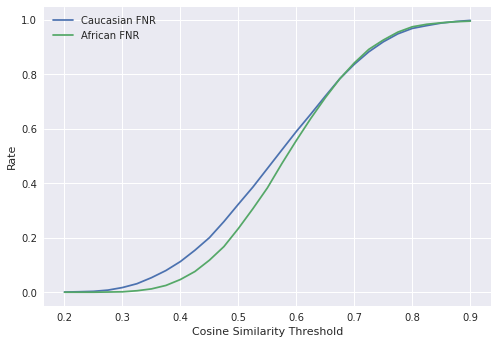

In [110]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
    plt.plot(thresholds,african_FNR,label='African FNR')
    # plt.plot(caucasian_mean_TPR,caucasian_mean_FNR,label='Caucasian mean FNR')
    # plt.plot(african_mean_TPR,african_mean_FNR,label='African mean FNR')
  


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()


In [46]:
### african genuine verificaiton
thresholds = np.arange(0,1.01,0.01)
african_TMR = []
african_FMR  = []
african_TNMR  = []
african_FNMR  = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = NIST_verification(african_cos, thresh,african_reference_identities,african_reference_ethnicities,african_candidate_identities)
    TMR = np.round(cos_verificaiton.mean(axis=0)['TMR'],4)
    FMR = np.round(cos_verificaiton.mean(axis=0)['FMR'],4)
    TNMR = np.round(cos_verificaiton.mean(axis=0)['TNMR'],4)
    FNMR = np.round(cos_verificaiton.mean(axis=0)['FNMR'],4)

    
    african_TMR.append(TMR)
    african_FMR.append(FMR)
    african_TNMR.append(TNMR)
    african_FNMR.append(FNMR)

african_TMR = np.array(african_TMR)
african_FMR = np.array(african_FMR)
african_TNMR = np.array(african_TNMR)
african_FNMR = np.array(african_FNMR)


  0%|          | 0/101 [00:00<?, ?it/s]

In [57]:
### caucasian genuine verificaiton
caucasian_TMR = []
caucasian_FMR  = []
caucasian_TNMR  = []
caucasian_FNMR  = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = NIST_verification(caucasian_cos, thresh,caucasian_reference_identities,caucasian_reference_ethnicities,caucasian_candidate_identities)
    TMR = np.round(cos_verificaiton.mean(axis=0)['TMR'],4)
    FMR = np.round(cos_verificaiton.mean(axis=0)['FMR'],4)
    TNMR = np.round(cos_verificaiton.mean(axis=0)['TNMR'],4)
    FNMR = np.round(cos_verificaiton.mean(axis=0)['FNMR'],4)

    
    caucasian_TMR.append(TMR)
    caucasian_FMR.append(FMR)
    caucasian_TNMR.append(TNMR)
    caucasian_FNMR.append(FNMR)

caucasian_TMR = np.array(caucasian_TMR)
caucasian_FMR = np.array(caucasian_FMR)
caucasian_TNMR = np.array(caucasian_TNMR)
caucasian_FNMR = np.array(caucasian_FNMR)


  0%|          | 0/101 [00:00<?, ?it/s]

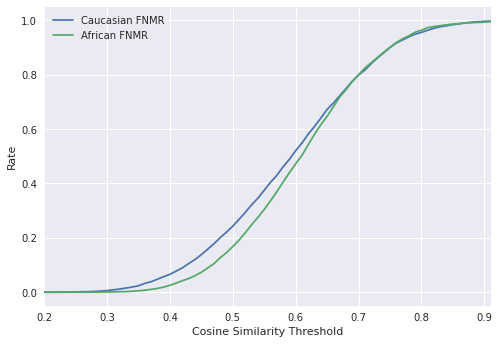

In [79]:
thresholds2 = np.arange(0,1.01,0.1)
with plt.style.context('seaborn'):    
    plt.plot(thresholds2,caucasian_FNMR,label='Caucasian FNMR')
    plt.plot(thresholds2,african_FNMR,label='African FNMR')
    
    
  


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
    plt.xlim(0.2,0.91)
plt.show()


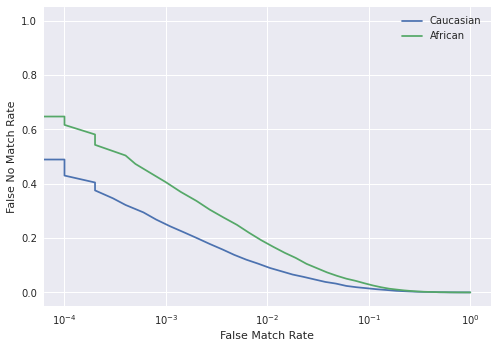

In [64]:
with plt.style.context('seaborn'):    
    # plt.plot(thresholds,african_FNMR,label='African FNMR')
    plt.plot((caucasian_FMR),caucasian_FNMR,label='Caucasian')
    plt.plot((african_FMR),african_FNMR,label='African')
  


    plt.xlabel('False Match Rate')
    plt.ylabel('False No Match Rate')
    plt.legend()
    plt.xscale('log')
plt.show()

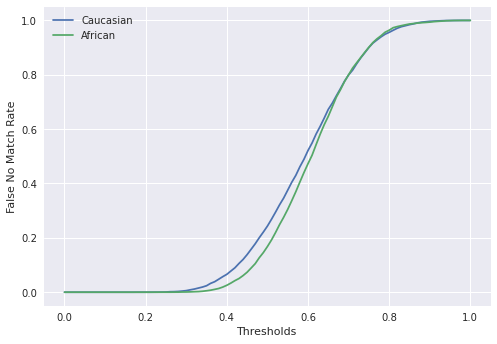

In [66]:
with plt.style.context('seaborn'):    
    # plt.plot(thresholds,african_FNMR,label='African FNMR')
    plt.plot(thresholds,caucasian_FNMR,label='Caucasian')
    plt.plot(thresholds,african_FNMR,label='African')
  


    plt.xlabel('Thresholds')
    plt.ylabel('False No Match Rate')
    plt.legend()
    # plt.xscale('log')
plt.show()

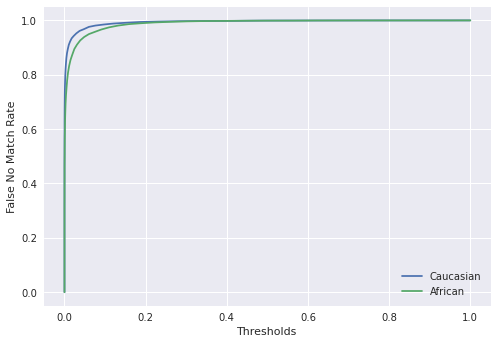

In [67]:
with plt.style.context('seaborn'):    
    plt.plot(caucasian_FMR,caucasian_TMR,label='Caucasian')
    plt.plot(african_FMR,african_TMR,label='African')
  


    plt.xlabel('Thresholds')
    plt.ylabel('False No Match Rate')
    plt.legend()
    # plt.xscale('log')
plt.show()

In [34]:
### asian genuine verificaiton
asian_TMR = []
asian_FMR  = []
asian_TNMR  = []
asian_FNMR  = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = NIST_verification(asian_cos, thresh,asian_reference_identities,asian_reference_ethnicities,asian_candidate_identities)
    TMR = np.round(cos_verificaiton.mean(axis=0)['TMR'],4)
    FMR = np.round(cos_verificaiton.mean(axis=0)['FMR'],4)
    TNMR = np.round(cos_verificaiton.mean(axis=0)['TNMR'],4)
    FNMR = np.round(cos_verificaiton.mean(axis=0)['FNMR'],4)

    
    asian_TMR.append(TMR)
    asian_FMR.append(FMR)
    asian_TNMR.append(TNMR)
    asian_FNMR.append(FNMR)

asian_TMR = np.array(asian_TMR)
asian_FMR = np.array(asian_FMR)
asian_TNMR = np.array(asian_TNMR)
asian_FNMR = np.array(asian_FNMR)


  0%|          | 0/101 [00:00<?, ?it/s]

In [36]:
### indian genuine verificaiton
indian_TMR = []
indian_FMR  = []
indian_TNMR  = []
indian_FNMR  = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = NIST_verification(indian_cos, thresh,indian_reference_identities,indian_reference_ethnicities,indian_candidate_identities)
    TMR = np.round(cos_verificaiton.mean(axis=0)['TMR'],4)
    FMR = np.round(cos_verificaiton.mean(axis=0)['FMR'],4)
    TNMR = np.round(cos_verificaiton.mean(axis=0)['TNMR'],4)
    FNMR = np.round(cos_verificaiton.mean(axis=0)['FNMR'],4)

    
    indian_TMR.append(TMR)
    indian_FMR.append(FMR)
    indian_TNMR.append(TNMR)
    indian_FNMR.append(FNMR)

indian_TMR = np.array(indian_TMR)
indian_FMR = np.array(indian_FMR)
indian_TNMR = np.array(indian_TNMR)
indian_FNMR = np.array(indian_FNMR)


  0%|          | 0/101 [00:00<?, ?it/s]

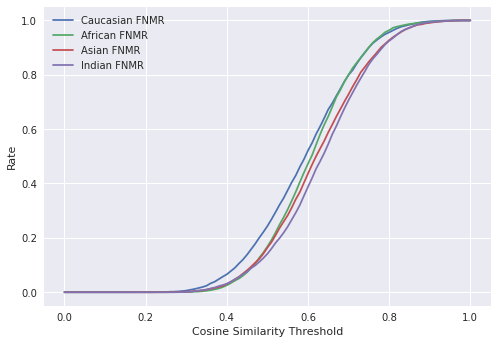

In [37]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,caucasian_FNMR,label='Caucasian FNMR')
    plt.plot(thresholds,african_FNMR,label='African FNMR')
    plt.plot(thresholds,asian_FNMR,label='Asian FNMR')
    plt.plot(thresholds,indian_FNMR,label='Indian FNMR')


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()


In [ ]:
np.save('african_TMR.npy',african_TMR)
np.save('african_TNMR.npy',african_TNMR)
np.save('african_FMR.npy',african_FMR)
np.save('african_FNMR.npy',african_FNMR)

np.save('caucasian_TMR.npy',caucasian_TMR)
np.save('caucasian_TNMR.npy',caucasian_TNMR)
np.save('caucasian_FMR.npy',caucasian_FMR)
np.save('caucasian_FNMR.npy',caucasian_FNMR)

np.save('asian_TMR.npy',asian_TMR)
np.save('asian_TNMR.npy',asian_TNMR)
np.save('asian_FMR.npy',asian_FMR)
np.save('asian_FNMR.npy',asian_FNMR)

np.save('indian_TMR.npy',indian_TMR)
np.save('indian_TNMR.npy',indian_TNMR)
np.save('indian_FMR.npy',indian_FMR)
np.save('indian_FNMR.npy',indian_FNMR)



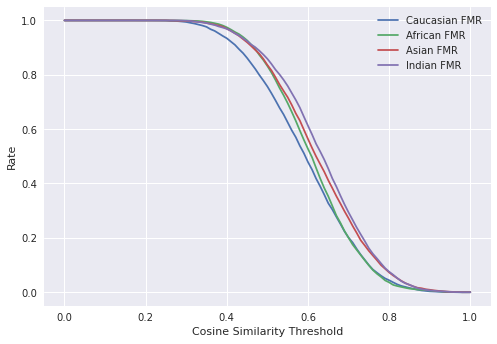

In [38]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,caucasian_FMR,label='Caucasian FMR')
    plt.plot(thresholds,african_FMR,label='African FMR')
    plt.plot(thresholds,asian_FMR,label='Asian FMR')
    plt.plot(thresholds,indian_FMR,label='Indian FMR')


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()


In [ ]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,african_FNR,label='African FNR')
    plt.plot(thresholds,african_TPR,label='African TPR')
    plt.plot(thresholds,african_mean_FNR,label='African mean_FNR')
    plt.plot(thresholds,african_mean_TPR,label='African mean_TPR')
    # plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
    # plt.plot(thresholds,caucasian_FPR,label='Caucasian FPR')
    # plt.plot(thresholds,caucasian_TPR,label='Caucasian TPR')
    # plt.plot(thresholds,caucasian_TNR,label='Caucasian TNR')
    # plt.plot(thresholds,african_FNR,label='African FNR')
    # plt.plot(thresholds,african_FPR,label='African FPR')
    # plt.plot(thresholds,african_TPR,label='African TPR')
    # plt.plot(thresholds,african_TNR,label='African TNR')


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()

In [ ]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
    plt.plot(thresholds,caucasian_TPR,label='Caucasian TPR')
    # plt.plot(thresholds,caucasian_mean_FNR,label='Caucasian mean_FNR')
    # plt.plot(thresholds,caucasian_mean_TPR,label='Caucasian mean_TPR')
  


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()


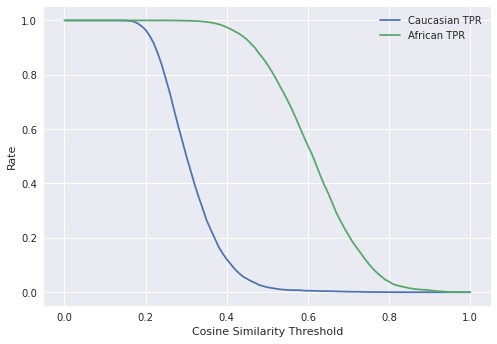

In [294]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,caucasian_TPR,label='Caucasian TPR')
    plt.plot(thresholds,african_TPR,label='African TPR')
  


    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()


In [197]:
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

caucasian_intersect = find_roots(thresholds,caucasian_FNR-caucasian_FPR)
caucasian_eer_idx = np.abs(thresholds-caucasian_intersect).argmin()
african_intersect = find_roots(thresholds,african_FNR-african_FPR)
african_eer_idx = np.abs(thresholds-african_intersect).argmin()

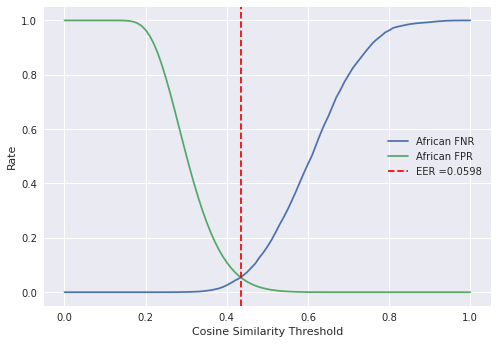

In [222]:
with plt.style.context('seaborn'):
    plt.plot(thresholds,african_FNR,label='African FNR')
    plt.plot(thresholds,african_FPR,label='African FPR')
    plt.axvline(x = african_intersect, color = 'r',label = 'EER =' +str(round(african_FPR[african_eer_idx],4)),linestyle='--')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()

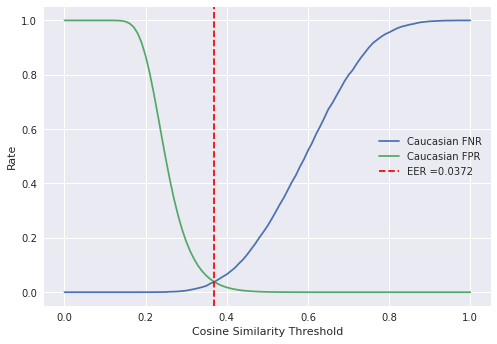

In [223]:
with plt.style.context('seaborn'):
    plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
    plt.plot(thresholds,caucasian_FPR,label='Caucasian FPR')
    plt.axvline(x = caucasian_intersect, color = 'r',label = 'EER =' +str(round(caucasian_FPR[caucasian_eer_idx],4)),linestyle='--')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()

37


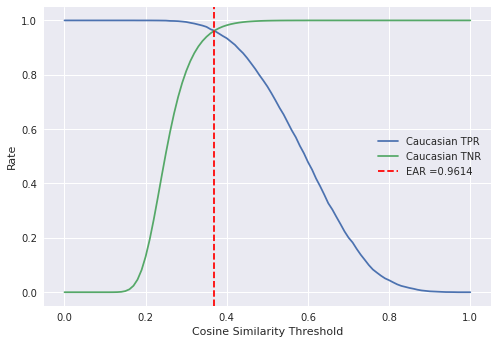

In [233]:
caucasian_intersect = find_roots(thresholds,caucasian_TNR-caucasian_TPR)
caucasian_ear_idx = np.abs(thresholds-caucasian_intersect).argmin()
print(caucasian_eer_idx)

with plt.style.context('seaborn'):    

    plt.plot(thresholds,caucasian_TPR,label='Caucasian TPR')
    plt.plot(thresholds,caucasian_TNR,label='Caucasian TNR')
    plt.axvline(x = caucasian_intersect, color = 'r',label = 'EAR =' +str(round(caucasian_TPR[caucasian_ear_idx],4)),linestyle='--')

    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()

43


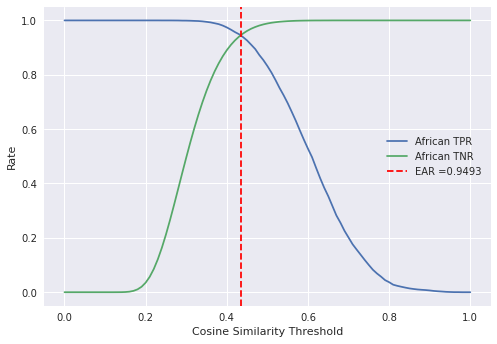

In [234]:
african_intersect = find_roots(thresholds,african_TNR-african_TPR)
african_ear_idx = np.abs(thresholds-african_intersect).argmin()
print(african_eer_idx)


with plt.style.context('seaborn'):    

    plt.plot(thresholds,african_TPR,label='African TPR')
    plt.plot(thresholds,african_TNR,label='African TNR')
    plt.axvline(x = african_intersect, color = 'r',label = 'EAR =' +str(round(african_TPR[african_ear_idx],4)),linestyle='--')

    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
plt.show()

In [51]:
# perform on asian images
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
asian_reference_dataset = resnetRFW(img_path,asian_references.reset_index(drop=True))
asian_reference_loader = torch.utils.data.DataLoader(asian_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
asian_candidate_dataset = resnetRFW(img_path,asian_candidates.reset_index(drop=True))
asian_candidate_loader = torch.utils.data.DataLoader(asian_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

asian_reference_outputs, asian_reference_identities, asian_reference_ethnicities, asian_reference_faceIDs = apply_model(model_ft,asian_reference_loader,'outputs/RFW/ft/reference2_asian',device)
asian_candidate_outputs, asian_candidate_identities, asian_candidate_ethnicities, asian_candidate_faceIDs = apply_model(model_ft,asian_candidate_loader,'outputs/RFW/ft/candidate2_asian',device)

asian_cor = corr2_coeff(asian_reference_outputs,asian_candidate_outputs).cpu().detach().numpy()
asian_cos = cos_sim(asian_reference_outputs,asian_candidate_outputs).cpu().detach().numpy()

asian_FNR = []
asian_FPR = []
asian_TNR = []
asian_TPR = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = verification(asian_cos, thresh,asian_reference_identities,asian_reference_ethnicities,asian_candidate_identities)
    TPR = np.round(cos_verificaiton.mean(axis=0)['TPR'],4)
    FPR = np.round(cos_verificaiton.mean(axis=0)['FPR'],4)
    TNR = np.round(cos_verificaiton.mean(axis=0)['TNR'],4)
    FNR = np.round(cos_verificaiton.mean(axis=0)['FNR'],4)
    asian_TPR.append(TPR)
    asian_FPR.append(FPR)
    asian_TNR.append(TNR)
    asian_FNR.append(FNR)

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/1797 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

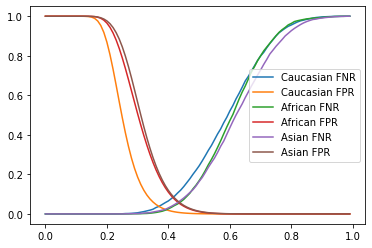

In [53]:
plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
plt.plot(thresholds,caucasian_FPR,label='Caucasian FPR')
plt.plot(thresholds,african_FNR,label='African FNR')
plt.plot(thresholds,african_FPR,label='African FPR')
plt.plot(thresholds,asian_FNR,label='Asian FNR')
plt.plot(thresholds,asian_FPR,label='Asian FPR')
plt.legend()
plt.show()

In [52]:
# perform on indian images
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
indian_reference_dataset = resnetRFW(img_path,indian_references.reset_index(drop=True))
indian_reference_loader = torch.utils.data.DataLoader(indian_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
indian_candidate_dataset = resnetRFW(img_path,indian_candidates.reset_index(drop=True))
indian_candidate_loader = torch.utils.data.DataLoader(indian_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

indian_reference_outputs, indian_reference_identities, indian_reference_ethnicities, indian_reference_faceIDs = apply_model(model_ft,indian_reference_loader,'outputs/RFW/ft/reference2_indian',device)
indian_candidate_outputs, indian_candidate_identities, indian_candidate_ethnicities, indian_candidate_faceIDs = apply_model(model_ft,indian_candidate_loader,'outputs/RFW/ft/candidate2_indian',device)

indian_cor = corr2_coeff(indian_reference_outputs,indian_candidate_outputs).cpu().detach().numpy()
indian_cos = cos_sim(indian_reference_outputs,indian_candidate_outputs).cpu().detach().numpy()

indian_FNR = []
indian_FPR = []
indian_TNR = []
indian_TPR = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = verification(indian_cos, thresh,indian_reference_identities,indian_reference_ethnicities,indian_candidate_identities)
    TPR = np.round(cos_verificaiton.mean(axis=0)['TPR'],4)
    FPR = np.round(cos_verificaiton.mean(axis=0)['FPR'],4)
    TNR = np.round(cos_verificaiton.mean(axis=0)['TNR'],4)
    FNR = np.round(cos_verificaiton.mean(axis=0)['FNR'],4)
    indian_TPR.append(TPR)
    indian_FPR.append(FPR)
    indian_TNR.append(TNR)
    indian_FNR.append(FNR)

processing: 0 images
processing: 0 images
processing: 5000 images


  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/1825 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

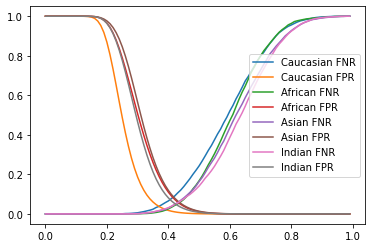

In [54]:
plt.plot(thresholds,caucasian_FNR,label='Caucasian FNR')
plt.plot(thresholds,caucasian_FPR,label='Caucasian FPR')
plt.plot(thresholds,african_FNR,label='African FNR')
plt.plot(thresholds,african_FPR,label='African FPR')
plt.plot(thresholds,asian_FNR,label='Asian FNR')
plt.plot(thresholds,asian_FPR,label='Asian FPR')
plt.plot(thresholds,indian_FNR,label='Indian FNR')
plt.plot(thresholds,indian_FPR,label='Indian FPR')
plt.legend()
plt.show()

In [31]:
ac_references = references[(references.Ethnicity=='African')|(references.Ethnicity=='Caucasian')]
ac_candidates = candidates[(candidates.Ethnicity=='African')|(candidates.Ethnicity=='Caucasian')]
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
ac_reference_dataset = resnetRFW(img_path,ac_references.reset_index(drop=True))
ac_reference_loader = torch.utils.data.DataLoader(ac_reference_dataset, batch_size=4, shuffle=False, **kwargs)
# load candidate images
ac_candidate_dataset = resnetRFW(img_path,ac_candidates.reset_index(drop=True))
ac_candidate_loader = torch.utils.data.DataLoader(ac_candidate_dataset, batch_size=4, shuffle=False, **kwargs)

processing: 0 images
processing: 5000 images
processing: 0 images
processing: 5000 images
processing: 10000 images


In [ ]:
ac_reference_outputs, ac_reference_identities, acreference_ethnicities, ac_reference_faceIDs = apply_model(model_ft,ac_reference_loader,'outputs/RFW/ft/reference2_ac',device)
ac_candidate_outputs, ac_candidate_identities, ac_candidate_ethnicities, accandidate_faceIDs = apply_model(model_ft,ac_candidate_loader,'outputs/RFW/ft/candidate2_ac',device)
ac_cor = corr2_coeff(ac_reference_outputs,ac_candidate_outputs).cpu().detach().numpy()
ac_cos = cos_sim(ac_reference_outputs,ac_candidate_outputs).cpu().detach().numpy()


In [148]:
ac_euc = all_pairs_euclid_torch(ac_reference_outputs,ac_candidate_outputs).cpu().detach().numpy()

In [149]:
ac_euc

array([[0.00768266, 0.00913762, 0.00644687, ..., 0.00630336, 0.0066644 ,
        0.00659165],
       [0.00688122, 0.00705634, 0.01196784, ..., 0.00641153, 0.00658497,
        0.00766266],
       [0.00711607, 0.00709032, 0.00659564, ..., 0.00646233, 0.0064775 ,
        0.00662655],
       ...,
       [0.00685585, 0.00720659, 0.00677966, ..., 0.00694747, 0.00699166,
        0.00714185],
       [0.00654593, 0.00703631, 0.00622633, ..., 0.00757167, 0.00731679,
        0.00684106],
       [0.00620286, 0.00653974, 0.00661181, ..., 0.00646529, 0.00655316,
        0.00748346]], dtype=float32)

In [ ]:
thresholds = np.arange(0,1.1,0.1)

african_FNR_list = []
african_FPR_list = []
african_TNR_list = []
african_TPR_list = []

caucasian_FNR_list = []
caucasian_FPR_list = []
caucasian_TNR_list = []
caucasian_TPR_list = []
for _, thresh in tqdm_notebook(enumerate(thresholds),total=len(thresholds)):
    cos_verificaiton = verification(ac_cos, thresh,ac_reference_identities,acreference_ethnicities,ac_candidate_identities)
    African_cos = cos_verificaiton.loc[cos_verificaiton.reference_ethnicity == 'African']
    Caucasian_cos = cos_verificaiton.loc[cos_verificaiton.reference_ethnicity == 'Caucasian']
    african_TPR = np.round(African_cos.mean(axis=0)['TPR'],4)
    african_FPR = np.round(African_cos.mean(axis=0)['FPR'],4)
    african_TNR = np.round(African_cos.mean(axis=0)['TNR'],4)
    african_FNR = np.round(African_cos.mean(axis=0)['FNR'],4)

    african_TPR_list.append(african_TPR)
    african_FPR_list.append(african_FPR)
    african_TNR_list.append(african_TNR)
    african_FNR_list.append(african_FNR)

    caucasian_TPR = np.round(Caucasian_cos.mean(axis=0)['TPR'],4)
    caucasian_TNR = np.round(Caucasian_cos.mean(axis=0)['TNR'],4)
    caucasian_FPR = np.round(Caucasian_cos.mean(axis=0)['FPR'],4)
    caucasian_FNR = np.round(Caucasian_cos.mean(axis=0)['FNR'],4)

    caucasian_TPR_list.append(caucasian_TPR)
    caucasian_FPR_list.append(caucasian_FPR)
    caucasian_TNR_list.append(caucasian_TNR)
    caucasian_FNR_list.append(caucasian_FNR)

    print('thresh =', np.round(thresh,4), 'african FPR =', african_FPR)
    print('thresh =', np.round(thresh,4), 'african TPR =', african_TPR)
    print('thresh =', np.round(thresh,4), 'caucasian FPR =', caucasian_FPR)
    print('thresh =', np.round(thresh,4), 'caucasian TPR =', caucasian_TPR)

In [ ]:
plt.plot(thresholds,caucasian_FNR_list,label='Caucasian')
# plt.plot(thresholds,caucasian_FPR,label='Caucasian FPR')
plt.plot(thresholds,african_FNR_list,label='African')
# plt.plot(thresholds,african_FPR,label='African FPR')
plt.xlabel('Cosine Similarity Threshold')
plt.ylabel('False Negative Rate')
plt.legend()
plt.show()

In [ ]:
# cosine similarity
'''
threshold = 0.48 African_TPR = 0.873
threshold = 0.48 African_FPR = 0.0097
threshold = 0.4025 Caucasian_TPR = 0.9306
threshold = 0.4025 Caucasian_FPR = 0.0098
'''

